In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy import signal as sig
import statsmodels.api as sm
import seaborn as sns
import warnings
from time import time
import copy 
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('data/valve1/1.csv',sep=';',index_col='datetime',parse_dates=True)

In [4]:
ind_start, ind_end = data.anomaly[data.anomaly == 1].index[0],data.anomaly[data.anomaly == 1].index[1]

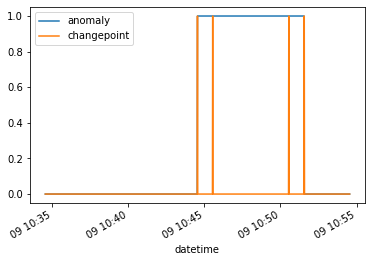

In [6]:
data.anomaly.plot()
data.changepoint.plot()
plt.legend()

In [10]:
# def evaluating(true_items, bin_metric):
    



def evaluate_nab(anomaly_list, bin_metric, table_of_coef=None):
    """
    Scoring labeled time series by means of
    Numenta Anomaly Benchmark methodics

    Parameters
    ----------
    anomaly_list: list of list of two float values
        The list of lists of left and right boundary indices
        for scoring results of labeling
    bin_metric: pd.Series with timestamp indices, in which 1 
        is change point, and 0 in other case. 
    table_of_coef: pandas array (3x4) of float values
        Table of coefficients for NAB score function
        indeces: 'Standart','LowFP','LowFN'
        columns:'A_tp','A_fp','A_tn','A_fn'


    Returns
    -------
    Scores: numpy array, shape of 3, float
        Score for 'Standart','LowFP','LowFN' profile 
    Scores_null: numpy array, shape 3, float
        Null score for 'Standart','LowFP','LowFN' profile             
    Scores_perfect: numpy array, shape 3, float
        Perfect Score for 'Standart','LowFP','LowFN' profile  
    """
    if table_of_coef is None:
        table_of_coef = pd.DataFrame([[1.0,-0.11,1.0,-1.0],
                             [1.0,-0.22,1.0,-1.0],
                              [1.0,-0.11,1.0,-2.0]])
        table_of_coef.index = ['Standart','LowFP','LowFN']
        table_of_coef.index.name = "Metric"
        table_of_coef.columns = ['A_tp','A_fp','A_tn','A_fn']

    alist = anomaly_list.copy()
    bin_metric = bin_metric.copy()

#         bin_metric = bin_metric.reset_index().drop_duplicates().set_index(bin_metric.index.name)
    Scores,Scores_perfect,Scores_null=[],[],[]
    for profile in ['Standart','LowFP','LowFN']:       
        A_tp = table_of_coef['A_tp'][profile]
        A_fp = table_of_coef['A_fp'][profile]
        A_fn = table_of_coef['A_fn'][profile]
        #TODO make 10% window if not known boundary
        #if len(list(al.values())[0])
        def sigm_scale(y,A_tp,A_fp,window=1):
            return (A_tp-A_fp)*(1/(1+np.exp(5*y/window))) + A_fp

        #First part
        score = 0
        if len(alist)>0:
            score += bin_metric[:alist[0][0]].sum()*A_fp
        else:
            score += bin_metric.sum()*A_fp
        #second part
        for i in range(len(alist)):
            if i<=len(alist)-2:
                win_space = bin_metric[alist[i][0]:alist[i+1][0]].copy()
            else:
                win_space = bin_metric[alist[i][0]:].copy()
            win_fault = bin_metric[alist[i][0]:alist[i][1]]
            slow_width = int(len(win_fault)/4)

            if len(win_fault) + slow_width >= len(win_space):
#                    не совсем так правильно лелать
                print('большая ширина плавного переходы сигмойды')
                win_fault_slow = win_fault.copy()
            else:
                win_fault_slow= win_space[:len(win_fault)  +  slow_width]

            win_fp = win_space[-len(win_fault_slow):]

            if win_fault_slow.sum() == 0:
                score+=A_fn
            else:
                #берем первый индекс
                tr = pd.Series(win_fault_slow.values,index = range(-len(win_fault),len(win_fault_slow)-len(win_fault)))
                tr_values= tr[tr==1].index[0]
                tr_score = sigm_scale(tr_values, A_tp,A_fp,slow_width)
                score += tr_score
                score += win_fp.sum()*A_fp
        Scores.append(score)
        Scores_perfect.append(len(alist)*A_tp)
        Scores_null.append(len(alist)*A_fn)
    list_metrics = np.array([np.array(Scores),np.array(Scores_null) ,np.array(Scores_perfect)])     
    sum1 = list_metrics
# довольно таки странная моя предыдушая запись
#     sum1 = np.zeros((3,3))
#     for i in range(len(list_metrics)):
#         sum1 += list_metrics[i]
    desc = ['Standart','LowFP','LowFN'] 
    for t in range(3):
        print(desc[t],' - ', round(100*(sum1[0,t]-sum1[1,t])/(sum1[2,t]-sum1[1,t]),2))


In [11]:
evaluate_nab([[ind_start, ind_end]],data.anomaly)

Standart  -  94.5
LowFP  -  89.0
LowFN  -  96.33
